# Train end-to-end model with SSL4EO backbone

In [1]:
import timm
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Load the dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))
img_dir = os.path.join(DATA_DIR, 'dhs_images')

Drop Egypt and Morrocco to only be Sub-Saharan Africa

In [3]:
df = df[~df['country'].isin(['Egypt', 'Morocco'])].reset_index(drop=True)

### Make folds

In [4]:
# Create equal-sized folds
folds = ['A', 'B', 'C', 'D', 'E']
df['cv_fold'] = np.nan  # Initialize the cv_fold column

# Generate and shuffle indices
indices = np.arange(len(df))
np.random.shuffle(indices)

# Split indices into equal-sized groups and assign folds
fold_indices = np.array_split(indices, len(folds))
for fold, idx in zip(folds, fold_indices):
    df.loc[idx, 'cv_fold'] = fold

df['cv_fold'].value_counts()

A    12102
B    12101
E    12101
C    12101
D    12101
Name: cv_fold, dtype: int64

### Init model

Initiate model. For more info, see https://huggingface.co/torchgeo/ssl4eo_landsat/tree/main

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def init_model():

    repo_id = "torchgeo/ssl4eo_landsat"
    filename = "resnet50_landsat_etm_sr_moco-1266cde3.pth"

    # Download the model weights
    backbone_path = hf_hub_download(repo_id=repo_id, filename=filename)

    # Create backbone model
    state_dict = torch.load(backbone_path)
    ssl4eo_backbone = timm.create_model("resnet50", in_chans=6, num_classes=0)
    ssl4eo_backbone.load_state_dict(state_dict)

    # Define model with regression head
    model = nn.Sequential(
        ssl4eo_backbone,
        nn.Dropout(p=0.2), # Dropout layer to prevent overfitting
        nn.Linear(2048, 1)
    ).to(device, memory_format=torch.channels_last) # Use channels_last memory format for better performance on GPUs

    return model

### Data loader

Code for dataloader

In [6]:
class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cluster_id = self.df.iloc[idx]['cluster_id']
        img_path = os.path.join(self.img_dir, cluster_id, 'landsat.np')
        img = np.load(img_path)
        target = (self.df.iloc[idx]['iwi'] / 100)
        if self.transform:
            img = self.transform(img)
        return img, target

In [7]:
def get_dataloaders(df, img_dir, train_folds, val_fold, test_fold, batch_size=128, num_workers=16):

    # Get the indices for each fold
    train_folds = df[df['cv_fold'].isin(train_folds)].index.tolist()
    val_fold = df[df['cv_fold'] == val_fold].index.tolist()
    test_fold = df[df['cv_fold'] == test_fold].index.tolist()

    landsat_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 0.0000275 - 0.2),
        transforms.Lambda(lambda x: torch.clamp(x, 0.0, 0.3)),
        transforms.Lambda(lambda x: x / 0.3)
    ])

    train_transform = transforms.Compose([
        landsat_transform,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
    ])

    train_dataset = RegressionDataset(df=df.iloc[train_folds], img_dir=img_dir, transform=train_transform)
    val_dataset = RegressionDataset(df=df.iloc[val_fold], img_dir=img_dir, transform=landsat_transform)
    test_dataset = RegressionDataset(df=df.iloc[test_fold], img_dir=img_dir, transform=landsat_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, val_dataloader, test_dataloader

Train model

In [15]:
def train_model(model, train_loader, val_loader, num_epochs=20, patience=5, lr=1e-4, weight_decay=1e-5, T_0=5, T_mult=2, device=device):

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)
    scaler = GradScaler()
    best_val_loss = float('inf')
    best_model_state = model.state_dict()
    steps_since_improvement = 0

    progress_bar = tqdm(range(num_epochs), desc="Training Progress")

    for epoch in progress_bar:
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            targets = targets.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs).squeeze()  # remove extra dim if needed
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
                targets = targets.to(device, dtype=torch.float32)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
        progress_bar.set_postfix({
            'Train Loss': epoch_loss,
            'Val Loss': val_loss,
            'Best Val Loss': best_val_loss
        })
        if steps_since_improvement >= patience:
            print(f"Early stopping triggered after {steps_since_improvement} epochs without improvement.")
            break
    
    model.load_state_dict(best_model_state)
    return model

In [8]:
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde

corrections_variables = {}

for fold in folds:
    print(f"Training for fold {fold}...")

    # Define train, validation, and test folds
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    print(f"Train folds: {train_folds}, Validation fold: {val_fold}, Test fold: {test_fold}")

    # Get dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df, img_dir, train_folds, val_fold, test_fold)

    # Initialize model
    model = init_model()

    # Train the model
    # model = train_model(model, train_dataloader, val_dataloader, num_epochs=20)

    # Save the model
    # torch.save(model.state_dict(), os.path.join(DATA_DIR, 'sub_saharan_models', f'model_fold_{fold}.pth'))

    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'sub_saharan_models', f'model_fold_{fold}.pth')))

    # Get test predictions
    print(f"Generating predictions for fold {test_fold}...")
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            test_predictions.extend(outputs.cpu().numpy())
    test_predictions = np.array(test_predictions)

    # Store predictions in the dataframe
    df.loc[df['cv_fold'] == test_fold, 'iwi_hat'] = test_predictions * 100  # Scale back to original range

    val_predictions = []
    with torch.no_grad():
        for inputs, _ in val_dataloader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
    val_predictions = np.array(val_predictions) * 100  # Scale back to original range

    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    val_predictions = np.array(val_predictions) * 100  # Scale back to original range the original range
    val_targets = np.array(val_targets) * 100  # Scale back to original range

    train_predictions = []
    train_targets = []
    with torch.no_grad():
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            train_predictions.extend(outputs.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())
    train_predictions = np.array(train_predictions) * 100  # Scale back to original range
    train_targets = np.array(train_targets) * 100  # Scale back to original range

    # Get value for Linear Correlation Correction (LCC)
    val_lcc_regressor = LinearRegression()
    val_lcc_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

    train_lcc_regressor = LinearRegression()
    train_lcc_regressor.fit(train_targets.reshape(-1, 1), train_predictions)

    # Get values for Tweedie's correction
    val_res_std = (val_predictions - val_targets).std()
    train_res_std = (train_predictions - train_targets).std()
    val_pred_kde = gaussian_kde(val_predictions)
    train_pred_kde = gaussian_kde(train_predictions)

    corrections_variables[fold] = {
        'val slope': val_lcc_regressor.coef_[0],
        'val intercept': val_lcc_regressor.intercept_,
        'train slope': train_lcc_regressor.coef_[0],
        'train intercept': train_lcc_regressor.intercept_,
        'val res std': val_res_std,
        'train res std': train_res_std,
        'val pred kde': val_pred_kde,
        'train pred kde': train_pred_kde
    }

# Save predictions to CSV
# df.to_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_imgs_predictions.csv'), index=False)

Training for fold A...
Train folds: ['C', 'D', 'E'], Validation fold: B, Test fold: A
Generating predictions for fold A...
Training for fold B...
Train folds: ['A', 'D', 'E'], Validation fold: C, Test fold: B
Generating predictions for fold B...
Training for fold C...
Train folds: ['A', 'B', 'E'], Validation fold: D, Test fold: C
Generating predictions for fold C...
Training for fold D...
Train folds: ['A', 'B', 'C'], Validation fold: E, Test fold: D
Generating predictions for fold D...
Training for fold E...
Train folds: ['B', 'C', 'D'], Validation fold: A, Test fold: E
Generating predictions for fold E...


In [9]:
corrections_variables

{'A': {'val slope': 0.7577956852740949,
  'val intercept': 5.559186859327244,
  'train slope': 0.9247088451402805,
  'train intercept': 1.147338718882601,
  'val res std': 9.77789234338965,
  'train res std': 5.681623465299889,
  'val pred kde': <scipy.stats._kde.gaussian_kde at 0x14ab2dcb0a00>,
  'train pred kde': <scipy.stats._kde.gaussian_kde at 0x14ab2dcb0040>},
 'B': {'val slope': 0.7490417969438614,
  'val intercept': 8.791666446499367,
  'train slope': 0.8697650604509963,
  'train intercept': 5.1344448475061775,
  'val res std': 9.670962559141708,
  'train res std': 6.652296204103213,
  'val pred kde': <scipy.stats._kde.gaussian_kde at 0x14ab0366d550>,
  'train pred kde': <scipy.stats._kde.gaussian_kde at 0x14aacbf2c5b0>},
 'C': {'val slope': 0.7633226425441377,
  'val intercept': 9.105409939362406,
  'train slope': 0.8867737297476733,
  'train intercept': 5.487846766954,
  'val res std': 9.762019781597326,
  'train res std': 6.434943314086991,
  'val pred kde': <scipy.stats._kd

In [10]:
def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

for fold in folds:
    fold_ixs = df['cv_fold'] == fold
    val_pred_kde = corrections_variables[fold]['val pred kde']
    prediction_scores = np.array([score_function(y, val_pred_kde) for y in tqdm(df[fold_ixs]['iwi_hat'])])
    df.loc[fold_ixs, 'val_prediction_scores'] = prediction_scores

    train_pred_kde = corrections_variables[fold]['train pred kde']
    train_prediction_scores = np.array([score_function(y, train_pred_kde) for y in tqdm(df[fold_ixs]['iwi_hat'])])
    df.loc[fold_ixs, 'train_prediction_scores'] = train_prediction_scores

df.to_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_pred_scores.csv'), index=False)

100%|██████████| 12101/12101 [00:44<00:00, 269.08it/s]


In [9]:
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde

corrections_variables = {}
save_variables = {}

for fold in folds:
    print(f"Training for fold {fold}...")

    # Define train, validation, and test folds
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    print(f"Train folds: {train_folds}, Validation fold: {val_fold}, Test fold: {test_fold}")

    # Get dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df, img_dir, train_folds, val_fold, test_fold)

    # Initialize model
    model = init_model()

    # Train the model
    #model = train_model(model, train_dataloader, val_dataloader, num_epochs=20)

    # Save the model
    #torch.save(model.state_dict(), os.path.join(DATA_DIR, 'cv_models', f'model_fold_{fold}.pth'))

    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'sub_saharan_models', f'model_fold_{fold}.pth')))

    # Get test predictions
    print(f"Generating predictions for fold {test_fold}...")
    model.eval()
    cal_predictions = []
    cal_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(train_dataloader):
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            cal_predictions.extend(outputs.cpu().numpy())
            cal_targets.extend(targets.cpu().numpy())
    cal_predictions = np.array(cal_predictions) * 100
    cal_targets = np.array(cal_targets) * 100

    # Get value for Linear Correlation Correction (LCC)
    lcc_regressor = LinearRegression()
    lcc_regressor.fit(cal_targets.reshape(-1, 1), cal_predictions)

    # Get values for Tweedie's correction
    res_std = (cal_predictions - cal_targets).std()
    pred_kde = gaussian_kde(cal_predictions)

    save_variables[fold] = {
        'lcc slope': lcc_regressor.coef_[0],
        'lcc intercept': lcc_regressor.intercept_,
        'res std': res_std,
        'cal_predictions': cal_predictions
    }

    corrections_variables[fold] = {
        'lcc slope': lcc_regressor.coef_[0],
        'lcc intercept': lcc_regressor.intercept_,
        'res std': res_std,
        'pred kde': pred_kde
    }

# Save predictions to CSV
#df.to_csv(os.path.join(DATA_DIR, 'dhs_with_imgs_predictions.csv'), index=False)

Training for fold A...
Train folds: ['C', 'D', 'E'], Validation fold: B, Test fold: A


Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Generating predictions for fold A...


100%|██████████| 284/284 [00:58<00:00,  4.89it/s]


Training for fold B...
Train folds: ['A', 'D', 'E'], Validation fold: C, Test fold: B
Generating predictions for fold B...


100%|██████████| 284/284 [00:55<00:00,  5.16it/s]


Training for fold C...
Train folds: ['A', 'B', 'E'], Validation fold: D, Test fold: C
Generating predictions for fold C...


100%|██████████| 284/284 [00:56<00:00,  5.06it/s]


Training for fold D...
Train folds: ['A', 'B', 'C'], Validation fold: E, Test fold: D
Generating predictions for fold D...


100%|██████████| 284/284 [00:55<00:00,  5.09it/s]


Training for fold E...
Train folds: ['B', 'C', 'D'], Validation fold: A, Test fold: E
Generating predictions for fold E...


100%|██████████| 284/284 [00:55<00:00,  5.08it/s]


In [12]:
list(save_variables[fold]['cal_predictions'])

[14.617673,
 18.100367,
 33.44571,
 11.394254,
 15.995473,
 14.195207,
 14.721139,
 12.396291,
 40.377228,
 18.096893,
 16.480364,
 32.69081,
 23.732914,
 24.216833,
 44.384163,
 55.8801,
 82.53344,
 11.552712,
 16.627604,
 9.564994,
 54.49864,
 22.727907,
 22.561296,
 13.119147,
 27.321753,
 35.758816,
 43.62824,
 36.719875,
 10.339951,
 15.803904,
 30.625296,
 15.404147,
 63.607735,
 16.802326,
 37.699802,
 36.98643,
 30.36409,
 11.977662,
 53.319675,
 61.612392,
 28.367191,
 20.114178,
 27.521423,
 34.249157,
 12.393963,
 15.955162,
 14.188251,
 16.20243,
 13.594392,
 28.822136,
 8.411709,
 20.087284,
 63.65726,
 27.377626,
 34.270744,
 40.157043,
 58.85014,
 20.300951,
 18.521559,
 54.646416,
 59.603085,
 16.172525,
 23.072294,
 18.646202,
 14.944209,
 27.172834,
 13.134459,
 63.33859,
 60.03008,
 8.324773,
 15.72729,
 16.979853,
 17.007204,
 75.6764,
 25.349745,
 43.332226,
 16.991611,
 22.303259,
 44.765144,
 24.43142,
 82.31146,
 16.519543,
 16.633877,
 18.749672,
 14.101924,
 1

In [14]:
save_variables

{'A': {'lcc slope': 0.9262011648514925,
  'lcc intercept': 1.1140114351388561,
  'res std': 5.650173658334523,
  'cal_predictions': [51.92527,
   25.860188,
   33.682304,
   9.1506405,
   16.740395,
   31.271362,
   51.511955,
   71.423325,
   50.513832,
   14.643508,
   23.457026,
   72.332016,
   23.678612,
   22.197666,
   21.880306,
   10.857773,
   31.282547,
   16.411718,
   52.13955,
   25.338385,
   17.576256,
   33.173843,
   27.681156,
   15.002701,
   46.671673,
   20.213955,
   19.356956,
   26.712387,
   17.664576,
   28.770483,
   9.720734,
   10.268785,
   35.881985,
   33.197166,
   3.8514633,
   16.946674,
   16.160349,
   15.896212,
   19.024586,
   11.438491,
   11.689607,
   12.951793,
   46.476696,
   12.763691,
   16.227907,
   12.211661,
   34.01659,
   36.68552,
   18.537924,
   17.532509,
   16.120314,
   21.126848,
   16.864641,
   18.695436,
   45.26217,
   14.301384,
   13.883841,
   55.15179,
   13.281538,
   44.020653,
   58.105618,
   44.725983,
   25.000

In [16]:
# Save save_variables as a json file
import json

# Convert all float32 values in save_variables to float for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, np.float32):  # Handle numpy float32
        return float(obj)
    else:
        return obj

serializable_save_variables = convert_to_serializable(save_variables)

with open(os.path.join(DATA_DIR, 'sub_saharan_models', 'save_variables.json'), 'w') as f:
    json.dump(serializable_save_variables, f)

In [3]:
# Save save_variables as a json file
import json
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde

# Load save_variables from JSON file
with open(os.path.join(DATA_DIR, 'sub_saharan_models', 'save_variables.json'), 'r') as f:
    loaded_save_variables = json.load(f)


corrections_variables = {}
folds = ['A', 'B', 'C', 'D', 'E']
for fold in folds:
    corrections_variables[fold] = {
        'lcc slope': loaded_save_variables[fold]['lcc slope'],
        'lcc intercept': loaded_save_variables[fold]['lcc intercept'],
        'res std': loaded_save_variables[fold]['res std'],
        'pred kde': gaussian_kde(loaded_save_variables[fold]['cal_predictions'])
    }

In [4]:
corrections_variables

{'A': {'lcc slope': 0.9262011648514925,
  'lcc intercept': 1.1140114351388561,
  'res std': 5.650173658334523,
  'pred kde': <scipy.stats._kde.gaussian_kde at 0x1485508aa910>},
 'B': {'lcc slope': 0.8689952707627341,
  'lcc intercept': 5.153465706923033,
  'res std': 6.666378879535677,
  'pred kde': <scipy.stats._kde.gaussian_kde at 0x1485508aa9a0>},
 'C': {'lcc slope': 0.8869670803343571,
  'lcc intercept': 5.501332007450301,
  'res std': 6.431770544146054,
  'pred kde': <scipy.stats._kde.gaussian_kde at 0x1485508aa940>},
 'D': {'lcc slope': 0.8569687199027656,
  'lcc intercept': 3.198204423983171,
  'res std': 6.006699315152747,
  'pred kde': <scipy.stats._kde.gaussian_kde at 0x1485508aaac0>},
 'E': {'lcc slope': 0.9380162241590966,
  'lcc intercept': 1.6486874815969053,
  'res std': 5.43794507532447,
  'pred kde': <scipy.stats._kde.gaussian_kde at 0x1485508aa9d0>}}

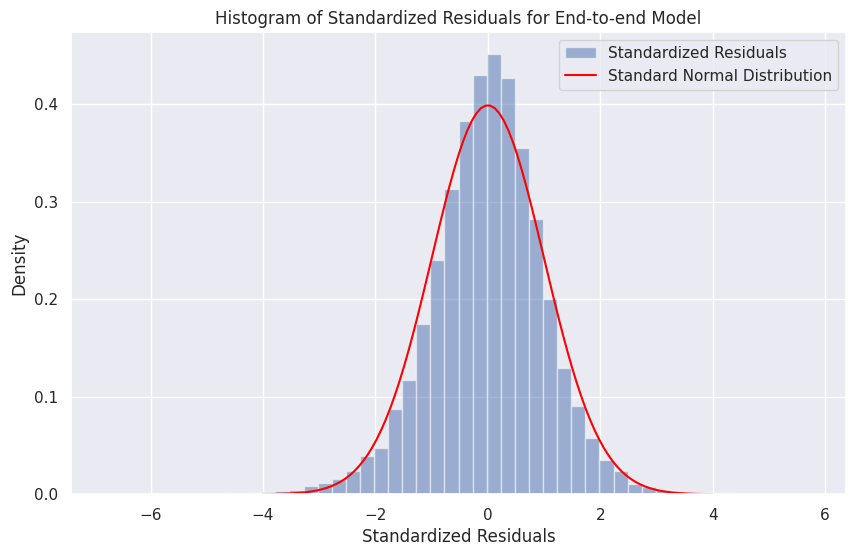

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

res = (cal_predictions - cal_targets)
norm_res = (res - res.mean()) / res.std()

# Plot histogram of residuals compared to normal distribution
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.hist(norm_res, bins=50, density=True, alpha=0.5, label='Standardized Residuals')
x = np.linspace(-4, 4, 100)
plt.plot(x, np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi), label='Standard Normal Distribution', color='red')
plt.title('Histogram of Standardized Residuals for End-to-end Model')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

In [14]:
from scipy.stats import normaltest

stat, p = normaltest((res - res.mean()) / res.std())
print("Statistics=%.3f, p=%.3f" % (stat, p))

if p > 0.05:
    print("Likely normal")
else:
    print("Likely not normal")


Statistics=590.093, p=0.000
Likely not normal


In [20]:
from scipy.stats import kurtosis, skew

print("Skewness:", skew(res))
print("Kurtosis:", kurtosis(res, fisher=True))  # >0 = leptokurtic, <0 = platykurtic


Skewness: -0.29322103019294216
Kurtosis: 1.5684221843639055


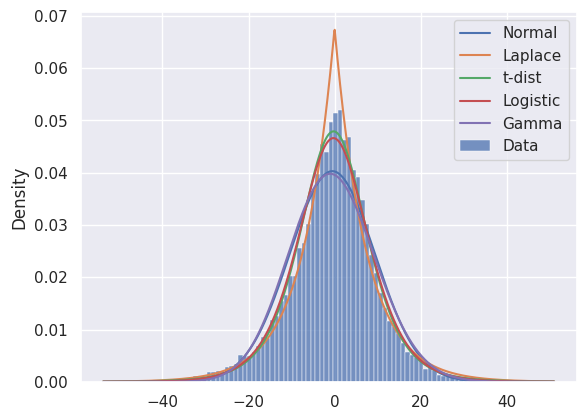

In [28]:
from scipy.stats import norm, laplace, t, logistic, gamma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
sns.histplot(res, kde=False, stat="density", bins=100, label="Data")

# Fit distributions
x = np.linspace(min(res), max(res), 1000)

# Normal
mu, std = norm.fit(res)
plt.plot(x, norm.pdf(x, mu, std), label="Normal")

# Laplace
loc, scale = laplace.fit(res)
plt.plot(x, laplace.pdf(x, loc, scale), label="Laplace")

# t-distribution
df, loc, scale = t.fit(res)
plt.plot(x, t.pdf(x, df, loc, scale), label="t-dist")

# Logistic
loc, scale = logistic.fit(res)
plt.plot(x, logistic.pdf(x, loc, scale), label="Logistic")

# Gamma
shape, loc, scale = gamma.fit(res)
plt.plot(x, gamma.pdf(x, shape, loc, scale), label="Gamma")

plt.legend()
plt.show()


In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_imgs_predictions.csv'))
df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,cv_fold,iwi_hat,prediction_scores,tweedie_iwi_hat,lcc_iwi_hat
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459,B,61.302357,-0.117665,72.307236,73.049370
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589,B,17.443792,-0.005974,18.002516,14.496476
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211,E,66.961580,-0.177117,84.330773,81.993079
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697,C,48.460380,-0.004434,48.882946,54.380694
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944,A,11.406880,0.195757,-7.308855,9.493525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60501,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567,A,21.945404,-0.097880,31.303447,23.400339
60502,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878,E,26.298725,-0.064190,32.593627,28.221159
60503,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326,C,27.319294,-0.063519,33.372457,26.684559
60504,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344,C,55.425423,-0.047151,59.918782,63.505331


In [33]:
folds = ['A', 'B', 'C', 'D', 'E']

hold_out_percentage = 0.1

corrections = []

df['PPI_iwi_hat'] = np.nan

for fold in folds:
    fold_ixs = df['cv_fold'] == fold
    hold_out_ixs = np.random.rand(len(df)) < hold_out_percentage

    fold_hold_out = df[fold_ixs & hold_out_ixs]
    fold_remaining = df[fold_ixs & ~hold_out_ixs]

    df.loc[fold_remaining.index, 'PPI_hold_out'] = False
    df.loc[fold_hold_out.index, 'PPI_hold_out'] = True

    for survey in fold_remaining['survey'].unique():
        survey_ixs = df['survey'] == survey
        hold_out_survey_ixs = fold_ixs & hold_out_ixs & survey_ixs
        survey_ppi_correction = (df[hold_out_survey_ixs]['iwi'] - df[hold_out_survey_ixs]['iwi_hat']).mean()
        df.loc[fold_ixs & survey_ixs, 'PPI_iwi_hat'] = df.loc[fold_ixs & survey_ixs, 'iwi_hat'] + survey_ppi_correction
        corrections.append(survey_ppi_correction)

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,cv_fold,iwi_hat,val_prediction_scores,train_prediction_scores,PPI_iwi_hat,PPI_hold_out,val_lcc_iwi_hat,train_lcc_iwi_hat
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459,B,61.302357,-0.117665,-0.096616,53.849720,False,70.103819,64.578257
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589,B,17.443792,-0.005974,-0.022473,9.991156,False,11.550925,14.152497
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211,E,66.961578,-0.177117,-0.132840,57.452370,True,79.879572,69.778948
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697,C,48.460381,-0.004434,0.000918,47.510967,False,51.557452,48.459412
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944,A,11.406880,0.195757,0.194538,18.339363,False,7.716715,11.094889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60501,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567,A,21.945404,-0.097880,-0.112552,30.488068,False,21.623529,22.491474
60502,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878,E,26.298725,-0.064190,-0.070876,28.364002,False,26.107652,26.291828
60503,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326,C,27.319294,-0.063519,-0.068018,23.981054,False,23.861318,24.618960
60504,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344,C,55.425423,-0.047151,-0.052484,52.087181,False,60.682089,56.313775


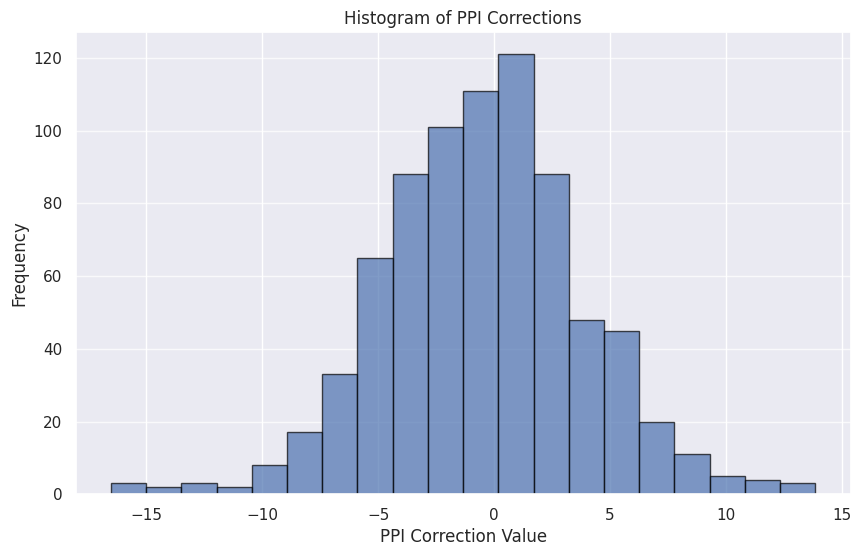

In [30]:
# Plot histogram of corrections
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(corrections, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of PPI Corrections')
plt.xlabel('PPI Correction Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

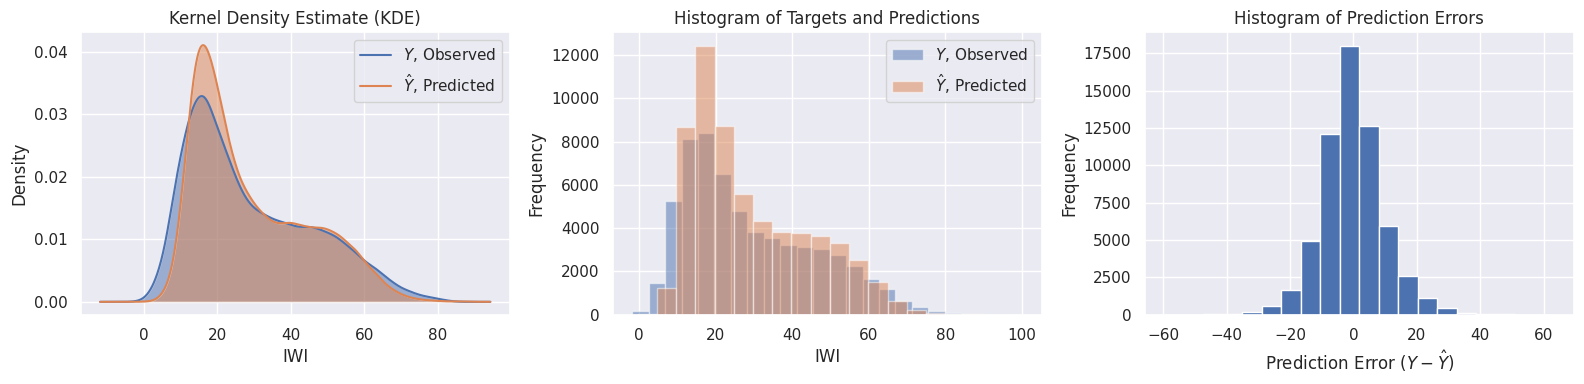

In [41]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

targets = df['iwi'].values
predictions = df['iwi_hat'].values

# Create KDE for marginal density p_Y(y)
target_kde = gaussian_kde(targets)
pred_kde = gaussian_kde(predictions)

# Create a range of x values to evaluate the KDE over
y_values = np.linspace(min(targets)-10, max(targets)+10, 1000)

# Evaluate the KDE over these x values
target_kde_values = target_kde(y_values)
pred_kde_values = pred_kde(y_values)

plt.figure(figsize=(16, 4))

# Plot the KDE
plt.subplot(1, 3, 1)
plt.plot(y_values, target_kde_values, label="$Y$, Observed")
plt.fill_between(y_values, target_kde_values, alpha=0.5)
plt.plot(y_values, pred_kde_values, label="$\hat{Y}$, Predicted")
plt.fill_between(y_values, pred_kde_values, alpha=0.5)
plt.title("Kernel Density Estimate (KDE)")
plt.xlabel("IWI")
plt.ylabel("Density")
plt.legend()

# Plot histogram of targets and predictions
plt.subplot(1, 3, 2)
plt.hist(targets, bins=20, alpha=0.5, label="$Y$, Observed")
plt.hist(predictions, bins=20, alpha=0.5, label="$\hat{Y}$, Predicted")
plt.title('Histogram of Targets and Predictions')
plt.xlabel('IWI')
plt.ylabel('Frequency')
plt.legend()

# Plot histogram of prediction errors
plt.subplot(1, 3, 3)
plt.hist(targets - predictions, bins=20)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error $(Y - \hat{Y})$')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

for fold in folds:
    fold_ixs = df['cv_fold'] == fold
    pred_kde = corrections_variables[fold]['pred kde']
    prediction_scores = np.array([score_function(y, pred_kde) for y in tqdm(df[fold_ixs]['iwi_hat'])])
    df.loc[fold_ixs, 'prediction_scores'] = prediction_scores

df.to_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_imgs_predictions2.csv'), index=False)

  0%|          | 0/12102 [00:00<?, ?it/s]

100%|██████████| 12101/12101 [00:47<00:00, 254.14it/s]


In [14]:
df2 = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs_predictions.csv'))

# Check if df and df2 are equal up to two decimal places
if np.allclose(df['iwi_hat'], df2['iwi_hat'], atol=0.01):
    print("The predictions match the saved predictions.")
else:
    print("The predictions do not match the saved predictions.")

The predictions match the saved predictions.


Make corrections

In [7]:
df['tweedie_iwi_hat'] = df.apply(lambda row: row['iwi_hat'] - corrections_variables[row['cv_fold']]['res std'] ** 2 * row['prediction_scores'], axis=1)
#df['lcc_iwi_hat'] = df.apply(lambda row: row['iwi_hat'] / corrections_variables[row['cv_fold']]['lcc slope'] - corrections_variables[row['cv_fold']]['lcc intercept'], axis=1)

In [21]:
df.to_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_imgs_predictions.csv'), index=False)

In [31]:
def tweedie_mean(df_i):

    tweedie_mean_hats = []

    for fold in folds:
        fold_df_i = df_i[df_i['cv_fold'] == fold]
        mean_hat = fold_df_i['iwi_hat'].mean()
        score = fold_df_i['val_prediction_scores'].mean()
        res_std = corrections_variables[fold]['train res std']
        tweedie_mean_hat = mean_hat - res_std**2 * score
        if not np.isnan(tweedie_mean_hat):
            tweedie_mean_hats.append(tweedie_mean_hat)
    return np.mean(tweedie_mean_hats)

#

In [15]:
df['val_lcc_iwi_hat'] = df.apply(lambda row: (row['iwi_hat'] - corrections_variables[row['cv_fold']]['val intercept']) / corrections_variables[row['cv_fold']]['val slope'], axis=1)
df['train_lcc_iwi_hat'] = df.apply(lambda row: (row['iwi_hat'] - corrections_variables[row['cv_fold']]['train intercept']) / corrections_variables[row['cv_fold']]['train slope'], axis=1)

In [47]:
df['tweedie_iwi_hat'] = df.apply(lambda row: row['iwi_hat'] - corrections_variables[row['cv_fold']]['train res std'] ** 2 * row['val_prediction_scores'], axis=1)
df['val_tweedie_iwi_hat'] = df.apply(lambda row: row['iwi_hat'] - corrections_variables[row['cv_fold']]['val res std'] ** 2 * row['val_prediction_scores'], axis=1)
df['train_tweedie_iwi_hat'] = df.apply(lambda row: row['iwi_hat'] - corrections_variables[row['cv_fold']]['train res std'] ** 2 * row['train_prediction_scores'], axis=1)

In [48]:
df.to_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_imgs_final.csv'), index=False)

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, 'sub_saharan_dhs_with_imgs_final.csv'))

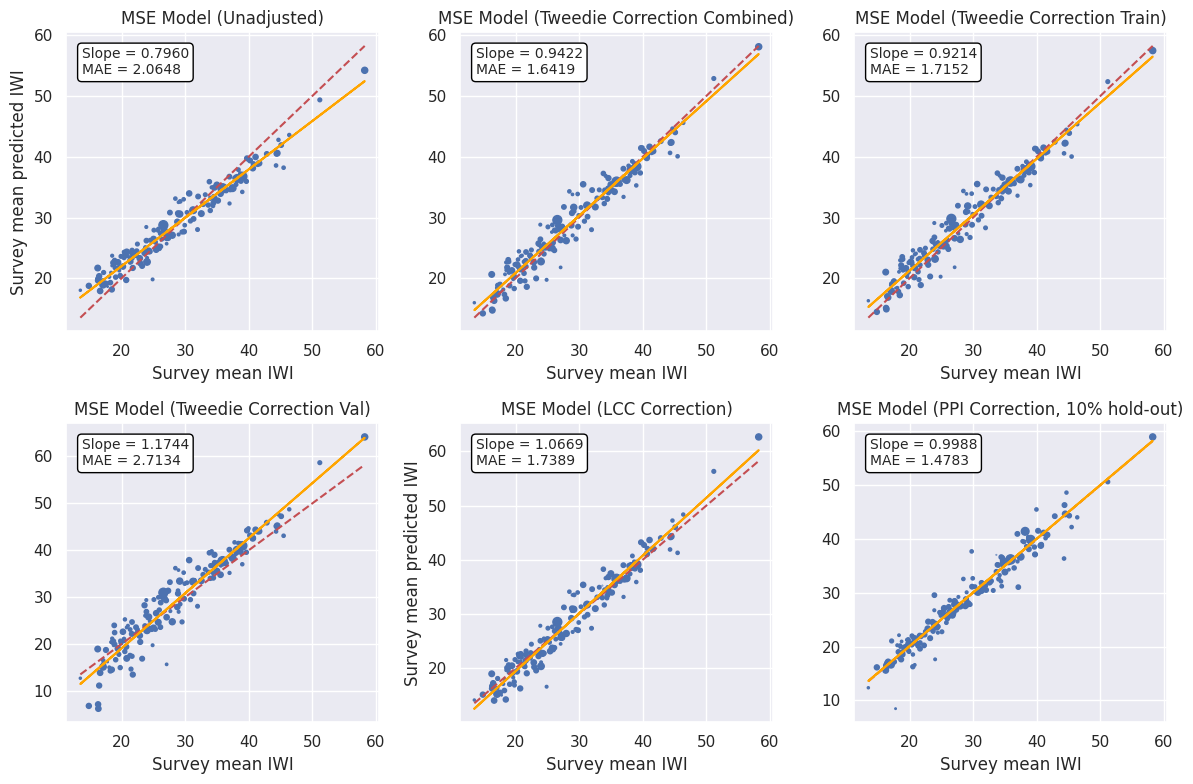

"#y = (df.groupby('survey')['iwi_hat'].mean() + df.groupby('survey')['tweedie_iwi_hat'].mean()) / 2\ny = df.groupby('survey').apply(tweedie_mean)\nplt.scatter(x, y, s=s)\ncountry_means_regression = LinearRegression()\ncountry_means_regression.fit(x.values.reshape(-1, 1), y.values)\nslope = country_means_regression.coef_[0]\nmae = mean_absolute_error(x, y)\nplt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,\n            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))\nplt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')\nplt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')\nplt.xlabel('Survey mean IWI')\nplt.ylabel('Survey mean predicted IWI')\nplt.title('MSE Model (Half Tweedie Correction)')\nplt.show()"

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

x = df.groupby('survey')['iwi'].mean()
s = df.groupby('survey')['iwi'].count()
s = 10*s / s.mean()

# Plot the Survey Means
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
# Plot points
y = df.groupby('survey')['iwi_hat'].mean()
plt.scatter(x, y, s=s)
# Add label with slope and MAE to plot
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.ylabel('Survey mean predicted IWI')
plt.title('MSE Model (Unadjusted)')

# Plot the Survey Means with Tweedie correction
plt.subplot(2, 3, 2)
#y = df.groupby('survey').apply(tweedie_mean) #
y = df.groupby('survey')['tweedie_iwi_hat'].mean()
plt.scatter(x, y, s=s)
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.title('MSE Model (Tweedie Correction Combined)')

plt.subplot(2, 3, 3)
#y = df.groupby('survey').apply(tweedie_mean) #
y = df.groupby('survey')['train_tweedie_iwi_hat'].mean()
plt.scatter(x, y, s=s)
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.title('MSE Model (Tweedie Correction Train)')

plt.subplot(2, 3, 4)
#y = df.groupby('survey').apply(tweedie_mean) #
y = df.groupby('survey')['val_tweedie_iwi_hat'].mean()
plt.scatter(x, y, s=s)
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.title('MSE Model (Tweedie Correction Val)')

# Plot the Survey Means with LCC correction
plt.subplot(2, 3, 5)
y = df.groupby('survey')['val_lcc_iwi_hat'].mean()
plt.scatter(x, y, s=s)
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.ylabel('Survey mean predicted IWI')
plt.title('MSE Model (LCC Correction)')

# Plot the Survey Means with PPI correction
plt.subplot(2, 3, 6)
y = df.groupby('survey')['PPI_iwi_hat'].mean()
plt.scatter(x, y, s=s)
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.title('MSE Model (PPI Correction, 10% hold-out)')
plt.tight_layout()
plt.show()


'''#y = (df.groupby('survey')['iwi_hat'].mean() + df.groupby('survey')['tweedie_iwi_hat'].mean()) / 2
y = df.groupby('survey').apply(tweedie_mean)
plt.scatter(x, y, s=s)
country_means_regression = LinearRegression()
country_means_regression.fit(x.values.reshape(-1, 1), y.values)
slope = country_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, country_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Survey mean IWI')
plt.ylabel('Survey mean predicted IWI')
plt.title('MSE Model (Half Tweedie Correction)')
plt.show()'''


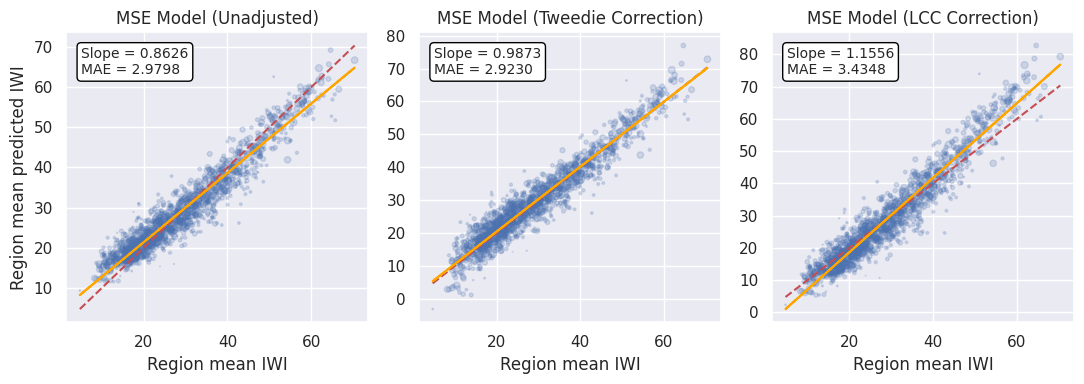

In [8]:
from sklearn.metrics import mean_absolute_error
import seaborn as sns

sns.set(style="darkgrid")

x = df.groupby(['region_id', 'survey'])['iwi'].mean()
s = df.groupby(['region_id', 'survey'])['iwi'].count()
s = 10*s / s.mean()

# Plot the Region Means
plt.figure(figsize=(11, 4))
plt.subplot(1, 3, 1)
# Plot points
y = df.groupby(['region_id', 'survey'])['iwi_hat'].mean()
plt.scatter(x, y, alpha=0.2, s=s)
# Add label with slope and MAE to plot
region_means_regression = LinearRegression()
region_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = region_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, region_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Region mean IWI')
plt.ylabel('Region mean predicted IWI')
plt.title('MSE Model (Unadjusted)')

# Plot the Region Means with Tweedie correction
plt.subplot(1, 3, 2)
y = df.groupby(['region_id', 'survey'])['tweedie_iwi_hat'].mean()
plt.scatter(x, y, alpha=0.2, s=s)
region_means_regression = LinearRegression()
region_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = region_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, region_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Region mean IWI')
plt.title('MSE Model (Tweedie Correction)')

# Plot the Region Means with LCC correction
plt.subplot(1, 3, 3)
y = df.groupby(['region_id', 'survey'])['val_lcc_iwi_hat'].mean()
plt.scatter(x, y, alpha=0.2, s=s)
region_means_regression = LinearRegression()
region_means_regression.fit(x.values.reshape(-1, 1), y.values, sample_weight=s)
slope = region_means_regression.coef_[0]
mae = mean_absolute_error(x, y)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
plt.plot(x, region_means_regression.predict(x.values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.xlabel('Region mean IWI')
plt.title('MSE Model (LCC Correction)')
plt.tight_layout()
plt.show()

38.22236260265319

R^2 Score: 0.7390


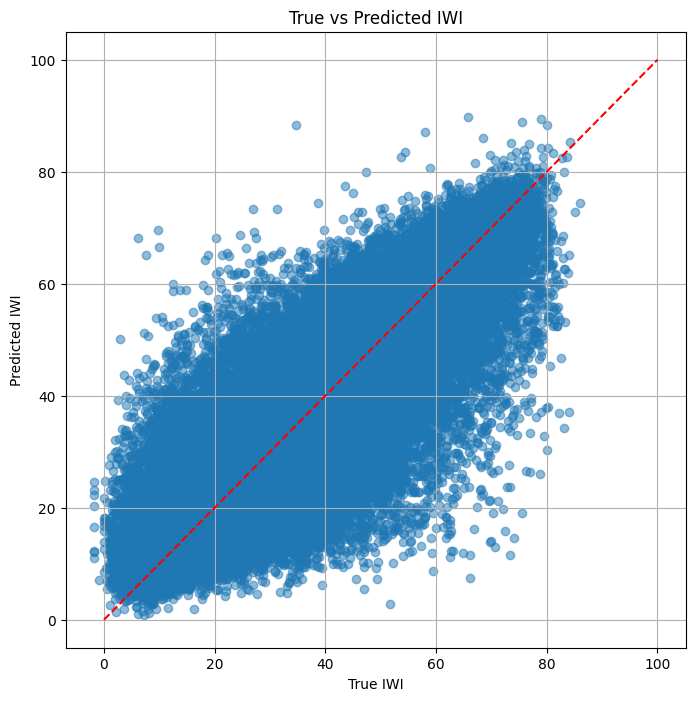

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(df['iwi'].values, df['iwi_hat'].values, alpha=0.5)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('True vs Predicted IWI')
plt.grid()

# Get R^2
from sklearn.metrics import r2_score
r2 = r2_score(df['iwi'].values, df['iwi_hat'].values)
print(f"R^2 Score: {r2:.4f}")

## Plot results

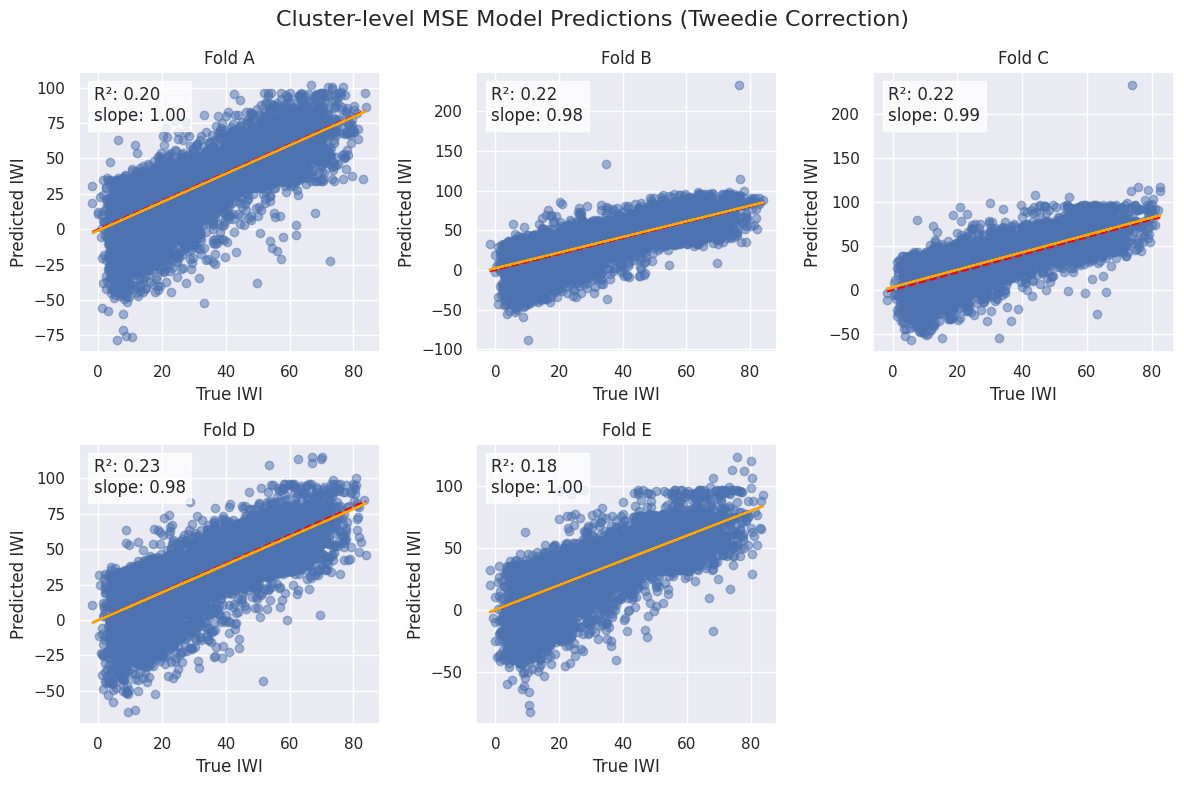

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

sns.set(style='darkgrid')

# Plot the sctatter plots for each fold in subplots
plt.figure(figsize=(12, 8))
for i, fold in enumerate('ABCDE'):
    plt.subplot(2, 3, i + 1)
    fold_data = df[df['cv_fold'] == fold]
    plt.scatter(fold_data['iwi'], fold_data['tweedie_iwi_hat'], alpha=0.5)
    plt.plot([fold_data['iwi'].min(), fold_data['iwi'].max()], [fold_data['iwi'].min(), fold_data['iwi'].max()], color='red', linestyle='--')

    # Add a box with R^2 and RMSE
    r2 = r2_score(fold_data['iwi'], fold_data['tweedie_iwi_hat'])
    slope_model = LinearRegression().fit(fold_data['iwi'].values.reshape(-1, 1), fold_data['tweedie_iwi_hat'])
    plt.plot(fold_data['iwi'], slope_model.predict(fold_data['iwi'].values.reshape(-1, 1)), color='orange', label='Regression Line')
    plt.text(0.05, 0.95, f'R²: {r2:.2f}\nslope: {slope_model.coef_[0]:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.xlabel('True IWI')
    plt.ylabel('Predicted IWI')
    plt.title(f'Fold {fold}')
plt.suptitle('Cluster-level MSE Model Predictions (Tweedie Correction)', fontsize=16)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Residuals (True - Predicted)')

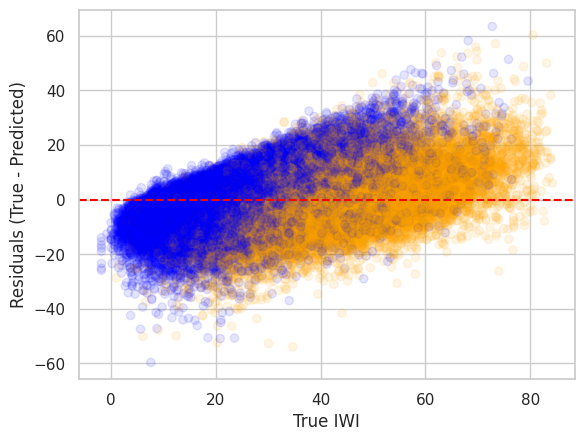

In [36]:
# Plot residuals colored by rural/urban status
plt.scatter(df['iwi'], df['iwi'] - df['iwi_hat'], alpha=0.1, c=df['rural'].map({True: 'blue', False: 'orange'}))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Residuals (True - Predicted)')

In [35]:
df['rural']

0        False
1         True
2        False
3         True
4         True
         ...  
60501     True
60502     True
60503     True
60504    False
60505    False
Name: rural, Length: 60506, dtype: bool